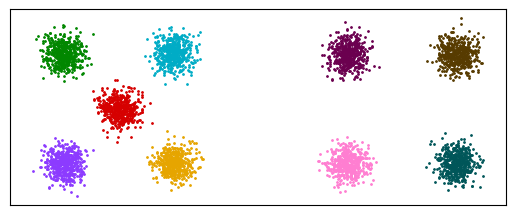

In [305]:
import collections
import functools
import itertools
from typing import Iterable, Union

import jscatter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable


def plot(a, b=None, ax=None):
    ax = ax or plt.gca()

    def _plot(data):
        ax.set_aspect("equal")
        ax.tick_params(
            left=False, right=False, labelleft=False, labelbottom=False, bottom=False
        )
        for (_, grp), color in zip(data.groupby("label"), jscatter.glasbey_dark):
            ax.scatter(grp.x, grp.y, color=color, s=1)

    _plot(a)
    if b is None:
        return

    ax = make_axes_locatable(ax).append_axes(
        "right", size="100%", pad=0.1, sharex=ax, sharey=ax
    )
    _plot(b)


def dataframe(generate_pts, labels: Iterable[str] = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"):
    """Collects sequence of X into a labeled pd.DataFrame"""

    def wrapper(*args, **kwargs):
        dfs = []
        for label, result in zip(labels, generate_pts(*args, **kwargs)):
            if isinstance(result, tuple):
                label, X = result
            else:
                X = result

            dfs.append(pd.DataFrame(dict(x=X[:, 0], y=X[:, 1], label=label)))

        df = pd.concat(dfs)
        df.label = df.label.astype("category")
        return df

    return wrapper


Covariance2D = tuple[tuple[float, float], tuple[float, float]]


@dataframe
def generate_data(
    neighborhood_offset: Union[float, None] = 13,
    x: float = 2.5,
    cov: Covariance2D = ((0.2, 0), (0, 0.2)),
    size: int = 500,
):
    means = [
        (0, 0),
        (-x, -x),
        (-x, x),
        (x, x),
        (x, -x),
    ]
    if neighborhood_offset is not None:
        means.extend(
            [
                (neighborhood_offset - x, -x),
                (neighborhood_offset - x, x),
                (neighborhood_offset + x, x),
                (neighborhood_offset + x, -x),
            ]
        )
    yield from map(
        functools.partial(np.random.multivariate_normal, cov=cov, size=size), means
    )


def translate(data, labels: list[str], offset: tuple[float, float] = (13, 0)):
    copy = data.copy()
    copy.loc[copy["label"].isin(labels), ["x", "y"]] += offset
    return copy


def rotate(data, labels: list[str], theta: float = np.radians(-45)):
    copy = data.copy()
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))

    mask = copy["label"].isin(labels)
    copy.loc[mask, ["x", "y"]] = copy.loc[mask, ["x", "y"]].values @ R.T

    return copy


data = generate_data()

plot(data)

### Case 1: Displacement

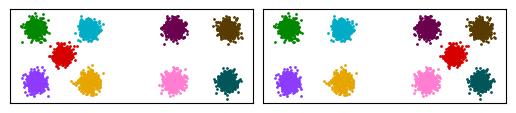

In [339]:
def case1():
    data = generate_data()
    return data, translate(data, labels=["A"])

plot(*case1())

### Case 2: Local rotation

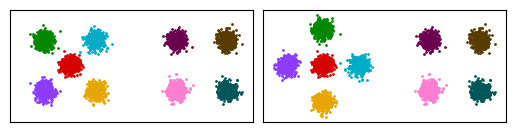

In [341]:
def case2():
    data = generate_data()
    return data, rotate(data, labels=["B", "C", "D", "E"])

plot(*case2())

### Case 3: Global rotation

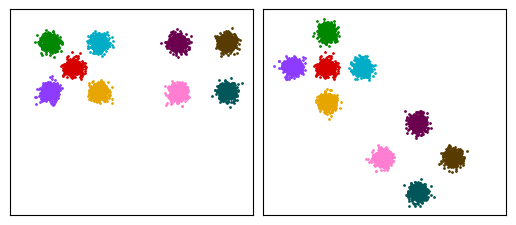

In [342]:
def case3():
    data = generate_data()
    return data, rotate(data, labels=["B", "C", "D", "E", "F", "G", "H", "I"])

plot(*case3())

### Case 4: Composition change

In [343]:
def downsample(data: pd.DataFrame, labels: list[str], frac: float = 0.5):
    dfs = []
    for label, df in data.groupby("label"):
        if label in labels:
            df = df.sample(frac=frac)
        dfs.append(df)
    return pd.concat(dfs).reset_index()

#### Case 4a: relative decrease

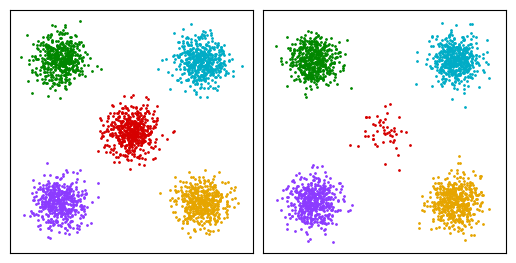

In [344]:
def case4a(frac: float = 0.1):
    a = generate_data(neighborhood_offset=None)
    b = downsample(generate_data(neighborhood_offset=None), labels=["A"], frac=frac)
    return a, b


plot(*case4a())

#### Case 4b: relative increase

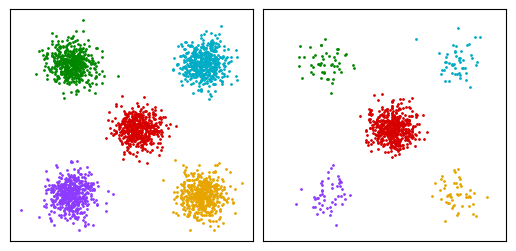

In [345]:
def case4b(frac: float = 0.1):
    a = generate_data(neighborhood_offset=None)
    b = downsample(
        generate_data(neighborhood_offset=None), labels=list("BCDE"), frac=frac
    )
    return a, b


plot(*case4b())

### Case 5: Neighborhood change

#### Case 5a: remove neighbor 

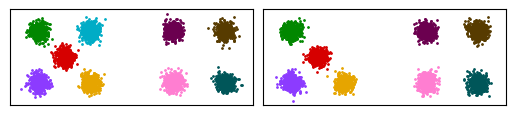

In [346]:
def case5a(label: str = "D"):
    a = generate_data()
    b = generate_data()
    return a, b[b.label != label].reset_index()


plot(*case5a())

#### Case 5b: swap groups

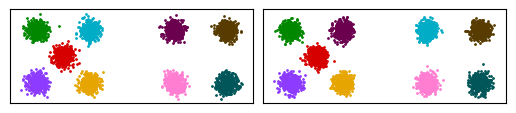

In [351]:
def case5b(swap: tuple[str, str]):
    a = generate_data()
    b = generate_data()
    src_mask, target_mask = map(lambda label: b.label == label, swap)
    b.label[src_mask] = swap[1]
    b.label[target_mask] = swap[0]
    return a, b.reset_index()

plot(*case5b(swap=("D", "G")))

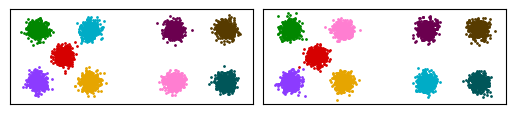

In [352]:
plot(*case5b(swap=("D", "F")))

#### Case 5c: dominant neighbor

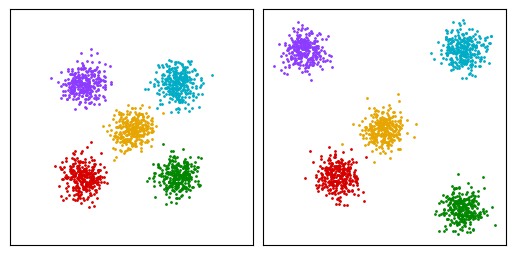

In [353]:
def case5c():
    @dataframe
    def _generate_data(
        x: float = 2,
        cov: Covariance2D = ((0.2, 0), (0, 0.2)),
        size: int = 300,
        factor: float = 1.0,
    ):
        yield np.random.multivariate_normal((-x, -x), cov, size)
        yield np.random.multivariate_normal((-factor * x, factor * x), cov, size)
        yield np.random.multivariate_normal((factor * x, -factor * x), cov, size)
        yield np.random.multivariate_normal((factor * x, factor * x), cov, size)
        yield np.random.multivariate_normal((0, 0), cov, size)

    return _generate_data(), _generate_data(factor=1.7)


plot(*case5c())

### Case 6: Confusion

copied from `confusion.ipynb`